1. Dataset Analysis: Explore the statistics and potential issues of the dataset.
2. Method Explanation: You should explain the method(s) you used.
3. Experiment Description: You should design a set of experiments in order to prove the advantage (if exists) of the proposed method.
4. Result Analysis: You should resume your experiment results and analyze them.


Multiple users in Kaggle have already conducted comprehensive analyses of the PFAM database. In this study, we leverage some of the existing tools to hilight certain aspects which have not be fully discussed yet. Bileschi et al. in their paper titled "Using Deep Learning to Annotate the Protein Universe" they present a remarkable convolutional neural network (CNN) surpasses the accuracy of both __BLAST__, which operates through pairwise alignment, and __hidden Markov models__ (pHMMs) based on scoring functions. This demonstrates the superior performance of the CNN in classifying the protein universe. 

In [3]:
import os

import numpy 
import pandas
import tensorflow

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Dataset Analysis:
Start by loading and exploring the dataset from the Pfam seed random split. Analyze the statistics of the dataset, such as the number of protein samples, the distribution of Pfam families, and any class imbalance issues. We visualize the data to gain insights, such as plotting the distribution of protein sequence lengths, examining the relationship between different features!

In [4]:
split_dataset = '/home/or22568/Desktop/PFAM/random_split' 
train_dataset_folder = f'{split_dataset}/train/'
test_dataset_folder = f'{split_dataset}/test/'
dev_dataset_folder = f'{split_dataset}/dev/'

In [5]:
# We use this help function to read the datasets
def read_data_csv(data_set_folder: str) -> pandas.DataFrame:
    files = []
    for file_name in os.scandir(data_set_folder): # scandir to get all files in the folder
        files.append(pandas.read_csv(file_name))  # array of pandas.DataFrame
    csv_pandas = pandas.concat(files)             # Concatenate the pandas.DataFrames
    return csv_pandas 

In [6]:
# We read the train, test and dev datasets present in the three folders 
train_dataset = read_data_csv(train_dataset_folder)
test_dataset = read_data_csv(test_dataset_folder)
dev_dataset = read_data_csv(dev_dataset_folder)

Data Structure (see https://www.kaggle.com/datasets/googleai/pfam-seed-random-split?resource=download): 

Each fold (train, dev, test) has a number of files in it. Each of those files
contains csv on each line, which has the following fields:

**sequence**: These are usually the input features to your model. Amino acid sequence for this domain.
There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite
uncommon: X, U, B, Z. This can be the training feature! 

**family_accession**: These are usually the labels for your model. Accession number in form PFxxxxx.y
(Pfam), where xxxxx is the family accession, and y is the version number. This is usually the Label!

**family_id**: One word name for family.

**sequence_name**: Sequence name, in the form "uniprot accession id/start index // end_index".

**aligned_sequence**: Contains a single sequence from the multiple sequence alignment (with the rest of the members of
the family in seed, with gaps retained. This can be the training feature! 

In [7]:
# We visually inspect the pandas.DataFrame initial fields
test_dataset.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGR..REVMAD....ACLQGMM..GCVYG..........TAG...,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGK.PVSRRTAAASATVLLG.EK..........AFWLV.......,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGT.C...D..VA...ME..AR.NQ.......T....G......,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKV..G.................KEYQLLN....CD...,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTD...............AMVVSSYLN..TDKSLV...,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...


In [8]:
# We visually inspect the pandas.DataFrame final fields
test_dataset.tail()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
12751,C1-set,IGHG2_CAVPO/229-315,PF07654.15,VYTLPPSRDE.LS.KSKVSVTCLIINFFP..ADIHVEWASNRVPVS...,VYTLPPSRDELSKSKVSVTCLIINFFPADIHVEWASNRVPVSEKEY...
12752,Cofac_haem_bdg,F0LPX5_VIBFN/30-233,PF04187.13,FRHAIRHADVILVGEWH..THTGIHRFQTDLLQTL..............,FRHAIRHADVILVGEWHTHTGIHRFQTDLLQTLSQEERPVALSMEQ...
12753,S-methyl_trans,A1B3D4_PARDP/21-337,PF02574.16,LI.....................LDGAMGTQI.Q....QL.........,LILDGAMGTQIQQLGLSETDFAGHGTGCACGCHPPAPGEHPQQGNN...
12754,Glyco_trans_1_4,B8FJ84_DESAA/245-385,PF13692.6,KNRLLVTN...SA.DT.....PLKGL.YHL..LKAV.HEVR....K...,KNRLLVTNSADTPLKGLYHLLKAVHEVRKKRDVTLTVIGAPKKHGG...
12755,OB_MalK,A0A0A0D4M6_9PROT/236-288,PF17912.1,GSPAMNFLPGT..V.V..RSDG.......LVARIDGQDL.PL...G...,GSPAMNFLPGTVVRSDGLVARIDGQDLPLGAYPFLSEPAAGDEIVL...


One crucial aspect to examine first is whether all the protein families are reported in the three subfolders and the number of proteins present in each subfolder.

In [9]:
def get_datasets_information(all_dataset: dict) -> pandas.DataFrame:
    columns = ['dataset', 'num_samples', 'num_families', 'min_samples_per_family', 'min_family', 'max_samples_per_family', 'max_family', 'mean_samples_per_family', 'name']
    data_analysis_info = pandas.DataFrame(columns=columns)
    
    for dataset_name, dataset in all_dataset.items():
        num_samples = len(dataset) # Total number of points
        num_families = dataset['family_accession'].nunique() # Number of nonunique family_accession
        fam_sizes = dataset.groupby('family_accession').size() # Number of protein for each family
        max_family = fam_sizes.idxmax() # Get the family corresponding to the maximum samples  
        min_family = fam_sizes.idxmin() # Get the family corresponding to the minimum samples  
        min_samples_per_family = fam_sizes.min()
        max_samples_per_family = fam_sizes.max()
        mean_samples_per_family = fam_sizes.mean()

        data_analysis_info = pandas.concat([data_analysis_info, pandas.DataFrame({'dataset': dataset_name,
                                                                                  'num_samples': num_samples,
                                                                                  'num_families': num_families,
                                                                                  'min_samples_per_family': min_samples_per_family,
                                                                                  'max_samples_per_family': max_samples_per_family,
                                                                                  'mean_samples_per_family': mean_samples_per_family,
                                                                                  'name': dataset_name,
                                                                                  'min_family': min_family,
                                                                                  'max_family': max_family}, index=[0])],
                                           ignore_index=True)
    return data_analysis_info


In [10]:
all_dataset = {'train': train_dataset, 'test': test_dataset, 'dev': dev_dataset}
get_datasets_information(all_dataset)

,dataset,num_samples,num_families,min_samples_per_family,min_family,max_samples_per_family,max_family,mean_samples_per_family,name
0,train,1086741,17929,1,PF00541.17,3637,PF13649.6,60.613587,train
1,test,126171,13071,1,PF00058.17,454,PF13649.6,9.652743,test
2,dev,126171,13071,1,PF00058.17,454,PF13649.6,9.652743,dev


Interestingly enough the protein family with less instances (1) in the "test" and "dev" databases is not the same of the train databse! In the following cell we notice that there are 17 instances of PF00058.17 in the train set.

PF13649.6 is instead the family more rapresented in all datasets. 

In [11]:
def get_protein_count(dataset: pandas.DataFrame, family_accession: str) -> int:
    count = len(dataset[dataset['family_accession'] == family_accession])
    return count

family_accession = 'PF00058.17'
count = get_protein_count(train_dataset, family_accession)
print(f"The number of instances of protein with family_accession {family_accession}: {count}")

The number of instances of protein with family_accession PF00058.17: 17


Upon initial analysis, it is evident that certain protein families are exclusively present in the training data, as indicated by the considerably higher number of families in the train partition compared to the other partitions. However, it remains uncertain whether there are families exclusive to the dev or test data. To gain further insights, we will delve deeper into the dataset and investigate if any families are exclusive to these partitions as well.

In [12]:
def intersection_common_families(dataset: pandas.DataFrame, dataset2: pandas.DataFrame) -> pandas.DataFrame: 
    return dataset.intersection(dataset2)


train_families = set(train_dataset['family_accession'])
dev_families = set(dev_dataset['family_accession'])
test_families = set(test_dataset['family_accession'])

if dev_families == test_families: 
    print(f'dev and test familes are the same')
    common_families = intersection_common_families(train_families, dev_families)

dev and test familes are the same


Based on the analysis, it is observed that there are exclusively unique protein families present only in the training dataset. To ensure a consistent validation process, it is advisable to exclude these families from the analysis. By doing so, the number of families will be consistent across all datasets (train, dev, and test). This approach ensures that the mapping of families can be effectively validated using the dev and test sets without any discrepancies.

In [13]:
train_dataset = train_dataset[train_dataset['family_accession'].isin(common_families)]
all_dataset['train'] = train_dataset
get_datasets_information(all_dataset)

,dataset,num_samples,num_families,min_samples_per_family,min_family,max_samples_per_family,max_family,mean_samples_per_family,name
0,train,1064950,13071,8,PF00245.20,3637,PF13649.6,81.474256,train
1,test,126171,13071,1,PF00058.17,454,PF13649.6,9.652743,test
2,dev,126171,13071,1,PF00058.17,454,PF13649.6,9.652743,dev


### Protein Family Analysis

In the paper of Bileschi et al. they noticed that some of the protein were much less represented than the others. We explore here some of the underlined statistics 

In [14]:
def plot_protein_families(all_dataset: dict) -> None:

    plt.figure(figsize=(30, 10))
    plt.suptitle('Distribution of family sizes', fontsize=28, y=0.95)
    # Define the colormap
    cmap = cm.viridis

    for n, (name, df) in enumerate(all_dataset.items()):
        ax = plt.subplot(1, 3, n + 1)
        ax.set_title(name, fontsize=26)
        ax.set_xlabel("Family size", fontsize=24)
        ax.set_ylabel("Number of families", fontsize=24)
        plt.tick_params(axis='both', which='both', length=6, labelsize=22)  
        df.groupby('family_id').size().hist(bins=200, ax=ax, color=cmap(n / len(all_dataset)))

        # Create inset plot for magnified view
        ax_inset = inset_axes(ax, width="70%", height="70%", loc='upper right')
        plt.tick_params(axis='both', which='both', length=6, labelsize=16)  # Increase tick size and font size
        ax_inset.set_xlabel("Family size", fontsize=20)
        ax_inset.set_ylabel("Number of families", fontsize=20)
        ax_inset.set_ylim(0, 10)
        df.groupby('family_id').size().hist(bins=100, ax=ax_inset, color=cmap(n / len(all_dataset)))

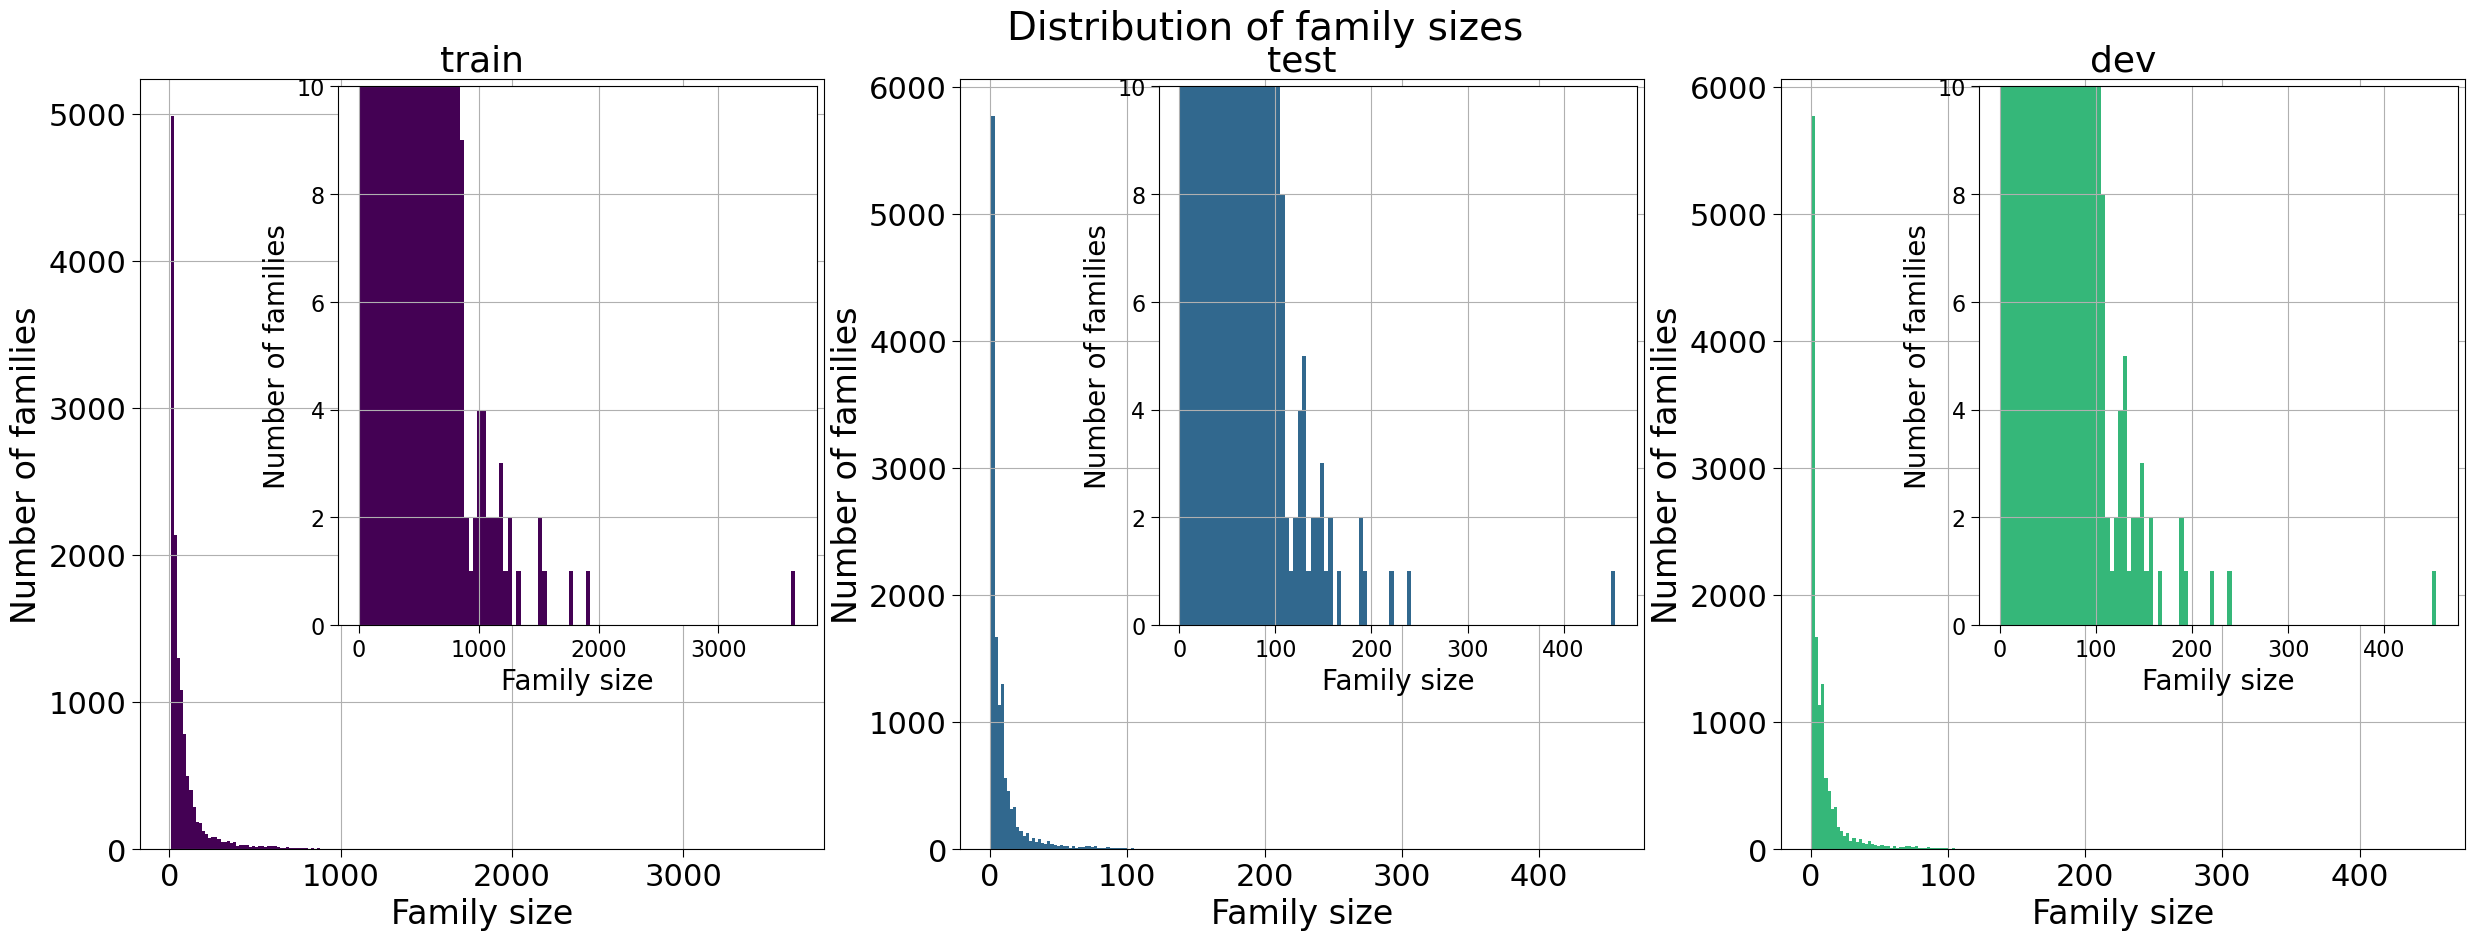

In [15]:
plot_protein_families(all_dataset=all_dataset)

The family size distributions observed in the graphs indicate that the distributions are consistent across the different sets. However, there is a notable prevalence of families with a small number of representatives and a scarcity of families with a large size. This could introduce bias in our neural network and machine learning models, as they may prioritize the more represented classes.

To address this issue, one potential solution is to reduce the number of protein families considered in the analysis by retaining only those that are well-represented in the dataset. However, it is important to note that this approach may not be optimal if our objective is to classify the entire proteome, including novel families that have not been previously classified. __Previusly some authors have already presented models featuring the 100 more frequent familes, here we will attempt to keep all familes and weight the NN to remove the overall bias__.


### Aminoacid distribution Analysis


In [16]:
def plot_protein_families(name: str, dataset: pandas.DataFrame) -> None:
    # Extract protein sequences from the dataset
    sequences = dataset['sequence']
    # Concatenate all sequences into a single string
    all_sequences = ''.join(sequences)
    # Calculate the frequency of each amino acid
    # Series in pandas has index, the value counts 
    aa_counts = pandas.Series(list(all_sequences)).value_counts()
  
    cmap = cm.viridis
    # Plot the amino acid distribution
    plt.figure(figsize=(12, 6))
    plt.title(f'Amino Acid Distribution in: {name} dataset', fontsize=24)
    plt.xlabel('Amino Acid Label', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.tick_params(axis='both', which='both', length=6, labelsize=16)  
    # Format y-axis ticks in millions
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    plt.gca().yaxis.set_major_formatter(formatter)
    # Plot
    plt.bar(aa_counts.index, aa_counts.values, color=cmap(0.7))

    # Create inset plot for magnified view
    ax_inset = inset_axes(plt.gca(), width="40%", height="50%", loc='upper right')
    ax_inset.set_xlabel('Amino Acid', fontsize=12)
    ax_inset.set_ylabel('Frequency', fontsize=12)
    ax_inset.tick_params(axis='both', which='both', length=4, labelsize=10) 
    ax_inset.bar(aa_counts.index, aa_counts.values, color=cmap(0.8))
    # Specify the threshold for magnification
    threshold = aa_counts.max() * 0.001
    # Set the limits for the magnified view
    ax_inset.set_ylim(aa_counts[aa_counts < threshold].values[-1], aa_counts[aa_counts < threshold].values[0])
    ax_inset.set_xlim(aa_counts[aa_counts < threshold].index[0], aa_counts[aa_counts < threshold].index[-1])


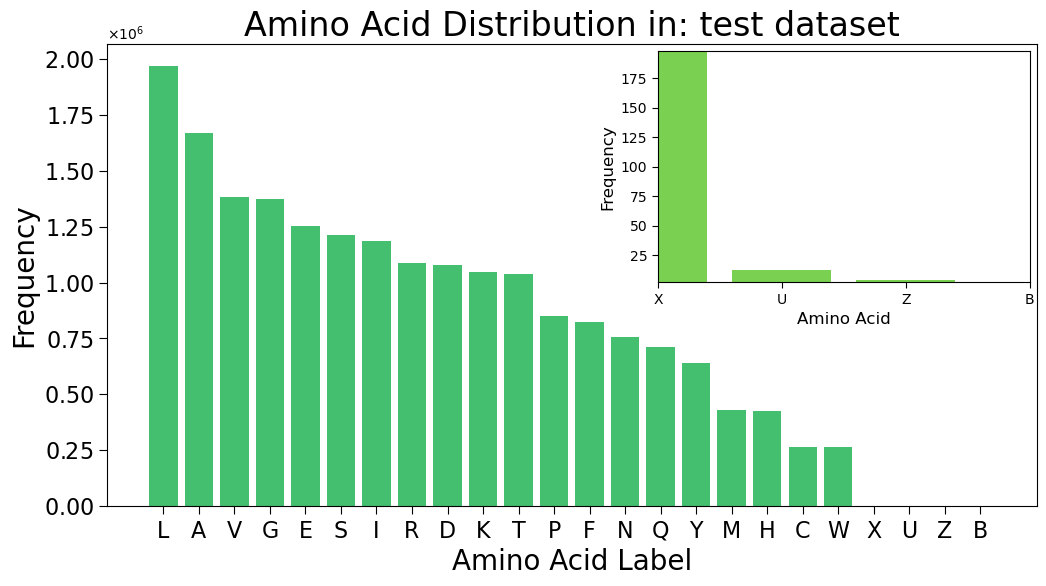

In [17]:
plot_protein_families(name='test', dataset=test_dataset)

Here we have examined the frequency of each amino acid in the protein sequences. According to the dataset description, there are 20 commonly occurring amino acids and 4 uncommon ones (X, U, B, Z). We see that Z and B are extremely rare.  

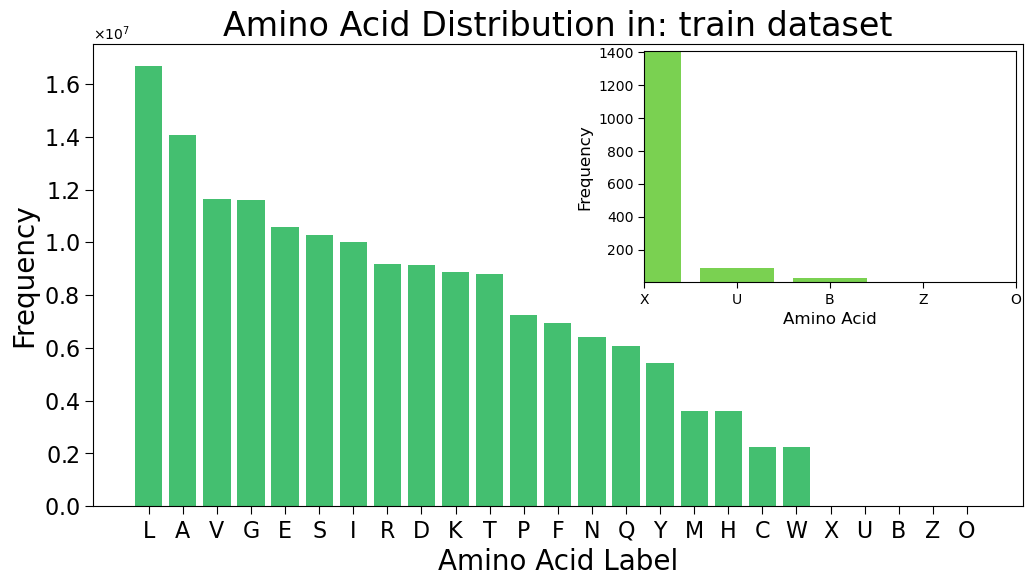

In [18]:
plot_protein_families(name='train', dataset=train_dataset)

In contrast to the previous analysis, we observe that the amino acid distribution varies between the training and test datasets, without reducing the number of families included. However, this heterogeneity in distribution should not pose a significant problem, as the rarest amino acids are expected to have a minor impact in the classification task.

## Method

We can draw inspiration from existing literature to develop a convolutional neural network (CNN) for the task of protein annotation based on sequence information. This task shares similarities with natural language processing, where the meaning of words in a sentence depends on the context provided by other words. Similarly, in image processing, features are recognized based on the non-local topology of the image. In the case of protein sequences, each amino acid carries information that is dependent on the other amino acids present in the peptide string. By applying convolutional procedures, we can encode information in a non-local manner, considering the interdependencies between amino acids rather than focusing on individual amino acids alone.

In [19]:
def amino_acids_dict() -> dict:
    # Encode the amino acids using one-hot encoding
    amino_acids = 'ACDEFGHIKLMNPQRSTVWYXUBOZ'  # List of amino acids
    num_classes = len(amino_acids)

    # Create a dictionary to map amino acids to indices
    dict_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    return dict_to_index

In [20]:
dict_amino_acids = amino_acids_dict()
print(dict_amino_acids)

{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20, 'U': 21, 'B': 22, 'O': 23, 'Z': 24}


### Econde Sequences

Here we encode the sequence of amino acids for the protein family selected. We need to reduce the overall size of the dataset otherwise we would require a huge ammount of memory.

In [21]:
# In the following I have faced some severe memory issue using the whole dataset. We cut some of the data. 
top_k = 100
def reduce_set_size(all_dataset: dict):
    
    most_freq_families = set(all_dataset['train']['family_accession'].value_counts()[:top_k].index)
    
    for name, df in all_dataset.items():
        all_dataset[name] = df[df['family_accession'].isin(most_freq_families)]
    
    return all_dataset

In [22]:
all_dataset = reduce_set_size(all_dataset)
get_datasets_information(all_dataset)

,dataset,num_samples,num_families,min_samples_per_family,min_family,max_samples_per_family,max_family,mean_samples_per_family,name
0,train,92983,100,708,PF02739.16,3637,PF13649.6,929.83,train
1,test,11565,100,88,PF01250.17,454,PF13649.6,115.65,test
2,dev,11565,100,88,PF01250.17,454,PF13649.6,115.65,dev


In [23]:
def convert_tensor(dataset: list):
    return tensorflow.convert_to_tensor(dataset, dtype=tensorflow.float32)

def reshape_list_and_convert(dataset: list) -> tensorflow.Tensor:
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], 1)
    converted_dataset = convert_tensor(dataset) 
    return converted_dataset

In [24]:
from typing import Tuple

def encode_sequence(all_dataset: dict, dict_amino_acids: dict, max_length: int) -> Tuple[numpy.ndarray]:
    encoded_list = []
    for n, (name, dataframe) in enumerate(all_dataset.items()):
        print(f'encoding {name}')
        set_list = []
        for sequence in dataframe['sequence']:
            sequence_list = [0 for i in range(max_length)]
            for index, amino_acid in enumerate(list(sequence[:max_length])):
                sequence_list[index] = dict_amino_acids[amino_acid]
            set_list.append(numpy.array(sequence_list))
        
        encoded_list.append(numpy.array(set_list))
    return encoded_list[0], encoded_list[1], encoded_list[2]

In [25]:
# Encode the sequences in the partitions
train_encoded, test_encoded, dev_encoded = encode_sequence(all_dataset=all_dataset, dict_amino_acids=dict_amino_acids, max_length=100)

encoding train
encoding test
encoding dev


In [26]:
# Encoded sequence of ammino acid
print(type(test_encoded), '\n', test_encoded[0])

<class 'numpy.ndarray'> 
 [17  9  2 17  0  1  5 16  1  2 17  0 10  3  0 14 11 13 16  5  2  0  0  4
  7  7  5 16  2  4 15 12  5 10  9 16  9  5  9 13  8  9  8  8 11 14 14  4
  0 16  7 12  9 17  1  0 11  0  9  0  9 12  4 13 15 16  6  4  2  0 17  9
  7  0  4  5  7 14 11  7 10  2 14  8  5  0  9  8 13  4  6  2  0  9  8 12
  5  5  0  0]


### Encode Labels

In [27]:
def dict_family(labels: list) -> Tuple[dict, int]:
    dict_family_accession = {}
    all_family_accession = set(labels)
    for i, family_accession in enumerate(all_family_accession):
        dict_family_accession[family_accession] = i
    return dict_family_accession, i+1 
        
def encode_labels(all_dataset: dict, dict_family_accession: dict, num_classes: int) -> Tuple[tensorflow.Tensor, tensorflow.Tensor, tensorflow.Tensor]:
    encoded_list = []
    for name, dataframe in all_dataset.items():
        print(f'encoding {name}')
        labels = dataframe['family_accession']
        labels_array = numpy.array([dict_family_accession[label] for label in labels])
        #print(labels.iloc[0:5], labels_array[0:5])
        encoded_labels = tensorflow.keras.utils.to_categorical(labels_array, num_classes=num_classes)
        encoded_list.append(encoded_labels)
        
    return encoded_list[0], encoded_list[1], encoded_list[2]

In [28]:
dict_family_accession, num_family_accession = dict_family(all_dataset['test']['family_accession'])
print(dict_family_accession, dict_family_accession)

{'PF02873.16': 0, 'PF03462.18': 1, 'PF00763.23': 2, 'PF01687.17': 3, 'PF01339.17': 4, 'PF14748.6': 5, 'PF00560.33': 6, 'PF00231.19': 7, 'PF02885.17': 8, 'PF00677.17': 9, 'PF02787.19': 10, 'PF00472.20': 11, 'PF01817.21': 12, 'PF01458.17': 13, 'PF02397.16': 14, 'PF07516.13': 15, 'PF00162.19': 16, 'PF00400.32': 17, 'PF02777.18': 18, 'PF01330.21': 19, 'PF01288.20': 20, 'PF02482.19': 21, 'PF01297.17': 22, 'PF13976.6': 23, 'PF01769.16': 24, 'PF02132.15': 25, 'PF00023.30': 26, 'PF10035.9': 27, 'PF01715.17': 28, 'PF02559.16': 29, 'PF02660.15': 30, 'PF01367.20': 31, 'PF00137.21': 32, 'PF01250.17': 33, 'PF01523.16': 34, 'PF01255.19': 35, 'PF00586.24': 36, 'PF00684.19': 37, 'PF13692.6': 38, 'PF01035.20': 39, 'PF02537.15': 40, 'PF13649.6': 41, 'PF02021.17': 42, 'PF02729.21': 43, 'PF04122.12': 44, 'PF02502.18': 45, 'PF00391.23': 46, 'PF08742.11': 47, 'PF02843.16': 48, 'PF05192.18': 49, 'PF02580.16': 50, 'PF00344.20': 51, 'PF17802.1': 52, 'PF01066.21': 53, 'PF00920.21': 54, 'PF01641.18': 55, 'PF0267

In [29]:
train_labels, test_labels, dev_labels = encode_labels(all_dataset=all_dataset, dict_family_accession=dict_family_accession, num_classes=num_family_accession)

encoding train
encoding test
encoding dev


In [30]:
print(all_dataset['train'].iloc[1], '\n\n') # 'PF13649.6': 86
print(all_dataset['dev'].iloc[4])           # 'PF13649.6': 86

family_id                                             Methyltransf_25
sequence_name                                     G8YSU8_PICSO/41-136
family_accession                                            PF13649.6
aligned_sequence    VLDVGCGP.G...S..IT...VD..IA.SR.......VP..K.......
sequence            VLDVGCGPGSITVDIASRVPKGHVTGIDTFEELISQGQQKASDLKQ...
Name: 4, dtype: object 


family_id                                             Methyltransf_25
sequence_name                                     D1C4C3_SPHTD/46-139
family_accession                                            PF13649.6
aligned_sequence    VLDLGCAN.G...A..TS...RA..LA.DL............G......
sequence            VLDLGCANGATSRALADLGARVTGVDVSARLIELARQREAARPRGV...
Name: 57, dtype: object


### CNN model

My first CNN model was simple: 
1 convolutional layer;
1 pool layer; 
1 flatten layer;
2 dense layers one with relu activation and 1 with softmax activation 

However such a simple model was not giving the accuracy I was seeking for the validation set

In [33]:
class CNNModel(tensorflow.keras.Model):
    def __init__(self, num_family_accession):
        super(CNNModel, self).__init__()
        self.conv1 = tensorflow.keras.layers.Conv1D(filters=16, kernel_size=7, activation='relu')
        self.pool1 = tensorflow.keras.layers.MaxPooling1D(pool_size=2)
        self.conv2 = tensorflow.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')
        self.pool2 = tensorflow.keras.layers.MaxPooling1D(pool_size=2)
        self.conv3 = tensorflow.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')
        self.pool3 = tensorflow.keras.layers.MaxPooling1D(pool_size=2)
        self.flatten = tensorflow.keras.layers.Flatten()
        self.dense1 = tensorflow.keras.layers.Dense(units=128, activation='relu')
        self.dense2 = tensorflow.keras.layers.Dense(units=num_family_accession, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output


CNN = CNNModel(num_family_accession)

In [34]:
# Compile the model
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
train_encoded_tensor = reshape_list_and_convert(train_encoded)
train_labels_tensor = convert_tensor(train_labels)

dev_encoded_tensor = reshape_list_and_convert(dev_encoded)
dev_labels_tensor = convert_tensor(dev_labels)

In [35]:
print("Shape:", tensorflow.shape(train_encoded_tensor))
print("Shape:", tensorflow.shape(train_labels_tensor))
print("Shape:", tensorflow.shape(dev_encoded_tensor))
print("Shape:", tensorflow.shape(dev_labels_tensor))

Shape: tf.Tensor([92983   100     1], shape=(3,), dtype=int32)
Shape: tf.Tensor([92983   100], shape=(2,), dtype=int32)
Shape: tf.Tensor([11565   100     1], shape=(3,), dtype=int32)
Shape: tf.Tensor([11565   100], shape=(2,), dtype=int32)


In [36]:
history = CNN.fit(train_encoded_tensor, train_labels_tensor, validation_data=(dev_encoded_tensor, dev_labels_tensor), epochs=10, batch_size=32)

2023-05-24 00:41:12.099201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-24 00:41:12.099536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz


Epoch 1/10
2906/2906 [==============================] - 8s 3ms/step - loss: 2.4695 - accuracy: 0.4156 - val_loss: 1.1186 - val_accuracy: 0.7179
Epoch 2/10
2906/2906 [==============================] - 8s 3ms/step - loss: 0.9873 - accuracy: 0.7469 - val_loss: 0.8989 - val_accuracy: 0.7677
Epoch 3/10
2906/2906 [==============================] - 9s 3ms/step - loss: 0.7636 - accuracy: 0.7998 - val_loss: 0.7601 - val_accuracy: 0.8011
Epoch 4/10
2906/2906 [==============================] - 10s 4ms/step - loss: 0.6282 - accuracy: 0.8325 - val_loss: 0.6592 - val_accuracy: 0.8285
Epoch 5/10
2906/2906 [==============================] - 10s 3ms/step - loss: 0.5313 - accuracy: 0.8595 - val_loss: 0.6582 - val_accuracy: 0.8321
Epoch 6/10
2906/2906 [==============================] - 10s 4ms/step - loss: 0.4642 - accuracy: 0.8744 - val_loss: 0.5759 - val_accuracy: 0.8500
Epoch 7/10
2906/2906 [==============================] - 10s 3ms/step - loss: 0.4044 - accuracy: 0.8904 - val_loss: 0.5351 - val_accur

Text(0, 0.5, 'Loss')

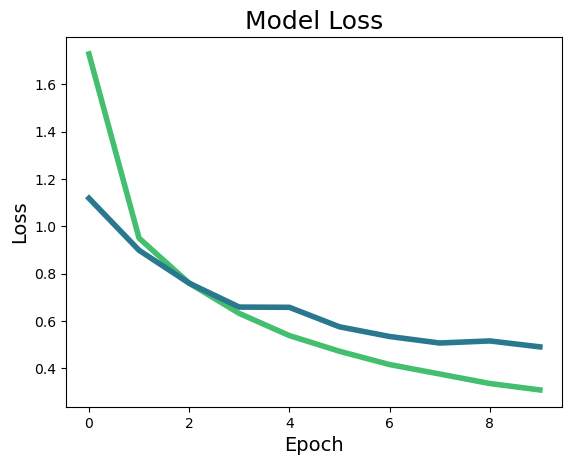

In [51]:
# Plotting the loss
cmap = cm.viridis

plt.plot(history.history['loss'], color=cmap(0.7), linewidth=4, label='Train')
plt.plot(history.history['val_loss'], color=cmap(0.4), linewidth=4, label='Validation')
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

Text(0, 0.5, 'Accuracy')

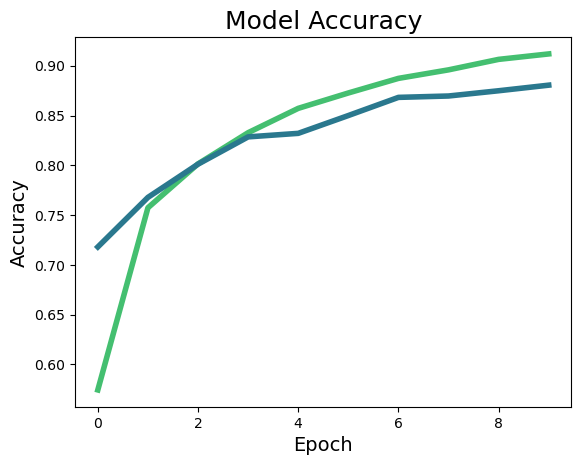

In [52]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], color=cmap(0.7), linewidth=4, label='Train')
plt.plot(history.history['val_accuracy'], color=cmap(0.4), linewidth=4, label='Validation')
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

The CNN model demonstrates remarkable accuracy on the __validation set__, indicating that it has successfully learned the significant and meaningful features within the dataset __without overfitting__.

I have used a __CNN as deep learning architecture for protein family classification__. It consists of convolutional, pooling, and dense layers that learn features from protein sequences. CNNs are beneficial for capturing __local patterns and motifs__, aiding in accurate classification. However, CNNs may struggle with complex relationships and interpretability. Further experiments can compare the CNN's performance with methods like BLAST and HMMs. Adjusting the CNN's architecture, hyperparameters, and exploring transfer learning can optimize its performance. 

Summary of future experiments and methods:

Compare CNN performance with BLAST and HMMs for sequence analysis.

Experiment with different CNN architectures, filter sizes, pooling strategies, and regularization techniques.

Fine-tune hyperparameters to enhance the CNN's predictive capabilities.

Explore transfer learning by leveraging pre-trained CNN models on large-scale protein datasets.

Consider data augmentation techniques to increase the diversity of the training set.

Explore hybrid approaches combining CNNs with other machine learning models or techniques.

Conduct comparative studies on different protein classification tasks to assess the generalizability of the CNN.